# Assignment 3 - Autoregressive Language Modeling with Transformers

In [14]:
%pip install torch==2.4.1 datasets==3.1.0


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import os
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

from datasets import load_dataset

# Data

In [16]:
import torch
from datasets import load_dataset

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, block_size=256):
        # Load dataset
        ds = load_dataset("Pablinho/movies-dataset")
        data = ds['train'].to_pandas()

        # Convert to pandas and create string format
        text_data = ""
        for _, row in data.iterrows():
            text_data += f"{row['Title']}: {row['Overview']}\n"

        # Create character mappings
        chars = sorted(list(set(text_data)))
        self.string_to_int = {ch:i for i,ch in enumerate(chars)}
        self.int_to_string = {i:ch for i,ch in enumerate(chars)}

        # Encode text to integers
        encoded_data = [self.string_to_int[c] for c in text_data]

        # Convert to tensor
        self.data = torch.tensor(encoded_data, dtype=torch.long)
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        x = chunk[:-1]  # all but last
        y = chunk[1:]   # all but first
        return x, y

    def decode(self, ids):
        return ''.join([self.int_to_string[i.item()] for i in ids])

# Model

In [17]:
@dataclass
class GPTConfig:
    vocab_size: int # Number of unique tokens in the vocabulary
    block_size: int = 256 # Sequence length
    n_block: int = 6 # Number of blocks in the transformer
    n_head: int = 6 # Number of attention heads
    n_embd: int = 384 # Embedding dimensionality
    dropout: float = 0.2 # Dropout rate
    bias: bool = True # If True, we add a bias to the LayerNorm and Linear layers.

In [18]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0, f"Embedding dimension {config.n_embd} must be divisible by number of heads {config.n_head}"

        self.n_head = config.n_head # Number of attention heads
        self.n_embd = config.n_embd # Embedding dimensionality
        self.dropout = config.dropout # Dropout rate

        # Maps embedding into Q, K, V. We'll use one layer to generate these matrices for all heads at once.
        # This is more efficient since everything can be computes as one single matrix multiplication.
        self.qkv_map = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        # After performing attention for each head individually, we project the results back to the embedding space.
        self.proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Regularization
        self.final_dropout = nn.Dropout(self.dropout)


    def forward(self, x):
        B, T, C = x.shape # batch size, sequence length, embedding dimensionality (n_embd)
        d_k = C // self.n_head # Dimension of the query and key (within a head)

        # TODO: Implement Causal Self Attention
        # Hint: The output of the qkv_map is a tensor of shape (B, T, 3*C).
        # We need to split this tensor into Q, K, and V tensors of shape (B, T, C) each. Split it in this precise order for the test function (see below) to work.
        # Afterwards, reshape and transpose them to the correct shape (see assert statements),
        # such that we have (smaller) Q, K, and V matrices for each head.

        # 1. Linear projection into Q, K, V separately
        qkv = self.qkv_map(x)  # (B, T, 3*C)
        Q, K, V = qkv.split(C, dim=2)  # each has shape (B, T, C)

        # 2. Reshape into multi-head format
        # split the embedding dimension into n_head × d_k
        Q = Q.view(B, T, self.n_head, d_k).transpose(1, 2)  # (B, n_head, T, d_k)
        K = K.view(B, T, self.n_head, d_k).transpose(1, 2)  # (B, n_head, T, d_k)
        V = V.view(B, T, self.n_head, d_k).transpose(1, 2)  # (B, n_head, T, d_k)


        for M in [Q, K, V]:
            assert M.shape == (B, self.n_head, T, d_k), f"Expected shape (B, self.n_head, T, d_k), but got {M.shape}"

        # TODO: Performs causally masked, multi-head scaled dot-product self-attention
        # Compute the attention weights and aggregated values.
        # Hint: Broadcasted matrix multiplication can be implemented using the @ operator.
        # Hint: `torch.tril` may help you with masking the attention scores. Set values to -inf before the softmax to get a softmax output of 0.

        # Compute attention scores
        attn_scores = (Q @ K.transpose(-2, -1)) / math.sqrt(d_k)  # (B, n_head, T, T)

        # Apply causal mask
        mask = torch.tril(torch.ones(T, T, device=x.device))
        attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        # Softmax + dropout
        attn_weights = F.softmax(attn_scores, dim=-1)  # (B, n_head, T, T)
        attn_weights = F.dropout(attn_weights, p=self.dropout, training=self.training)

        # Weighted sum of values
        aggregated_vals = attn_weights @ V  # (B, n_head, T, d_k)

        assert aggregated_vals.shape == (B, self.n_head, T, d_k), f"Expected aggregated_vals shape (B, self.n_head, T, d_k), but got {aggregated_vals.shape}"

        # Combine all head outputs into the last dimension
        out = aggregated_vals.transpose(1, 2).reshape(B, T, C)
        out = self.proj(out) # This combines the outputs of all heads
        out = self.final_dropout(out) # This is the final dropout layer

        return out

You can test your implementation of the `CausalSelfAttention` class by running the following code:

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = GPTConfig(vocab_size=10, block_size=8, n_block=6, n_head=6, n_embd=12, dropout=0.0, bias=True)

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

x = torch.randn(2, 8, 12).to(device)
attention = CausalSelfAttention(config).to(device)
att_out = attention(x)

# Read expected output from file
att_out_expected = torch.load('CausalSelfAttention_out.pt', map_location=device)

assert torch.allclose(att_out, att_out_expected)

/var/folders/m_/4w751xsx21xd9q6gkq4v_nbc0000gn/T/ipykernel_1799/4285277868.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  att_out_expected = torch.load('CausalSelfAtte

In [20]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Implement the MLP
        # It should consist of a linear layer, a GELU activation function, and a final linear layer.
        # After the final linear layer, apply dropout with dropout rate config.dropout.
        # The first linear layer should map from config.n_embd to 4 * config.n_embd.
        # The second linear layer should map from 4 * config.n_embd back to config.n_embd.
        # The linear layers should have a bias term if config.bias is True, and no bias term otherwise.

        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)


    def forward(self, x):
        # TODO: Implement the forward pass of the MLP

        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [21]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.attention = CausalSelfAttention(config)
        self.layernorm_2 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attention(self.layernorm_1(x))
        x = x + self.mlp(self.layernorm_2(x))
        return x

In [22]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            embed_token = nn.Embedding(config.vocab_size, config.n_embd),
            embed_position = nn.Embedding(config.block_size, config.n_embd),
            dropout = nn.Dropout(config.dropout),
            blocks = nn.ModuleList([Block(config) for _ in range(config.n_block)]),
            layernorm = nn.LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # We use the same weights for the token embeddings and the final linear layer, since they in principal do the same thing.
        # This can help speed up training.
        # For more information, you can have a look at https://doi.org/10.48550/arXiv.1608.05859
        self.transformer.embed_token.weight = self.head.weight

        # Initialize all linear layers using our custom init function
        self.apply(self._init_params)

        # report number of parameters
        print(f"Number of parameters in GPT: {self.get_num_params()/1e6:.2f}M")


    def _init_params(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def get_num_params(self):
        unique_params = {id(p) : p.numel() for p in self.parameters()}
        return sum(unique_params.values())


    def forward(self, idx):
        device = idx.device
        b, t = idx.shape
        assert t <= self.config.block_size, f"Cannot process sequence of length {t}, block size is only {self.config.block_size}"
        position_idxs = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # TODO: Implement the forward pass of the GPT model
        # Embed the tokens and positions using the embedding layers self.transformer.embed_token and self.transformer.embed_position.
        # Add the token embeddings and position embeddings together and pass the result through the dropout layer.
        # Pass the result through all the transformer blocks.
        # Apply layer normalization and finally obtain the logits by project the result to
        # the vocabulary space using the head layer.

        # Token and position embedding
        tok_emb = self.transformer.embed_token(idx)  # (B, T, n_embd)
        pos_emb = self.transformer.embed_position(position_idxs)  # (T, n_embd)
        pos_emb = pos_emb.unsqueeze(0)  # (1, T, n_embd)
        x = tok_emb + pos_emb

        # Dropout
        x = self.transformer.dropout(x)

        # Transformer blocks
        for block in self.transformer.blocks:
            x = block(x)

        # Final layer norm
        x = self.transformer.layernorm(x)

        # Output head
        # logits = self.transformer.head(x) # (B, T, vocab_size)
        logits = self.head(x)  # (B, T, vocab_size)

        return logits


    def get_optimizer(self, weight_decay, learning_rate, betas, device):
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}

        # We will decay all parameters that are 2D or higher dimensional.
        # This includes all weight matrices and embeddings.
        decay_params = [p for n, p in param_dict.items() if len(p.shape) >= 2]
        # We will not decay biases and layernorm parameters (which are 1D).
        nodecay_params = [p for n, p in param_dict.items() if len(p.shape) < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]

        fused = (device == 'cuda')
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, fused=fused)

        return optimizer


    @torch.no_grad()
    def sample(self, idx, max_new_tokens, temperature=1.0):
        # idx is of shape (batch_size, sequence_length)

        for _ in range(max_new_tokens):
            # If the sequence context is growing too long we must crop it at block_size
            idx_input = idx if idx.shape[1] <= self.config.block_size else idx[:, -self.config.block_size:]
            # TODO: Push idx_input through the model to get the logits for the next token in the sequence
            # Hint: The logits that are returned by the model are of shape (batch_size, sequence_length, vocab_size).
            # To predict the next token, we only need the logits for the last position in the sequence.
            # Next, divide the logits by the desired temperature and apply the softmax function to convert them to probabilities.
            # Finally, sample the next token from this probability distribution.

            # Forward pass
            logits = self(idx_input)  # (B, T, vocab_size)

            # Extract logits for the last position and scale
            logits = logits[:, -1, :] / temperature  # (B, vocab_size)

            # Convert scaled logits into a probability distribution
            probs = F.softmax(logits, dim=-1) # (B, vocab_size)

            # Sample next token
            next_token = torch.multinomial(probs, num_samples=1)

            assert next_token.shape == (idx.shape[0], 1), f"Expected next_token shape (batch_size, 1), but got {next_token.shape}"

            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, next_token), dim=1)

        return idx

# Training

In [23]:
@torch.no_grad()
def estimate_train_val_loss(model, train_loader, val_loader, val_iters, device):
    model.eval()
    losses = {}
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        total_loss = 0
        for i, (X, Y) in enumerate(loader):
            if i >= val_iters:
                break
            X, Y = X.to(device), Y.to(device)
            logits = model(X)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), Y.view(-1), ignore_index=-1)
            total_loss += loss.item()
        losses[split] = total_loss / val_iters
    model.train()

    return losses

In [24]:
# Set seeds for reproducibility
torch.manual_seed(1337)

block_size = 128
batch_size = 128

# Create datasets and dataloaders
data = MovieDataset(block_size)

# split into train and validation sets
train_len = int(len(data) * 0.8)
val_len = len(data) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

# TODO: You may fetch a batch from the dataloader here to answer Task a)


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

out_dir = 'MovieGPT'
checkpoint_path = os.path.join(out_dir, 'checkpoint.pt')
os.makedirs(out_dir, exist_ok=True)  # Create output directory

# TODO: You may change the training configuration as desired, especially in Task h)
# You may also add loops for automated hyperparameter search and
# timestamps to track training time.

# Eval/Logging
val_interval = 500 # Number of iterations between evaluations
val_iters = 20 # Number of iterations for evaluation
log_interval = 10 # Number of iterations between logging

# Optimizer settings
learning_rate = 1e-3 # Larger networks typically require a learning rate that is smaller than this
max_iters = 5_000 # Number of iterations to train for
weight_decay = 1e-1 # Weight decay for regularization (on the weights/embeddings)
beta1, beta2 = 0.9, 0.99 # Beta1, Beta2 for AdamW optimizer
grad_clip = 1.0 # Clip gradients at this value, or disable if == 0.0

# Compile model
compile_model = False # Compile the model for faster execution. Note: no debug breakpoints in compiled models!

# Model config
vocab_size = len(data.string_to_int)
config = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_block=4,
    n_head=4,
    n_embd=128,
    dropout=0.0,
    bias=False
) # This is a relatively small model

# ===== Task i) START: Larger model =====

config_large = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_block=6,
    n_head=8,
    n_embd=256,
    dropout=0.0,
    bias=False
)

model_large = GPT(config_large).to(device)

optimizer_large = model_large.get_optimizer(
    weight_decay, learning_rate, (beta1, beta2), device
)

# ===== Task i) END: Larger model =====

model = GPT(config).to(device)

if compile_model:
    print("Compiling the model...")
    model = torch.compile(model) # Needs PyTorch >= 2.0
    print("Done compiling")

# Initialize optimizer
optimizer = model.get_optimizer(weight_decay, learning_rate, (beta1, beta2), device)

# Training loop
iter_num = 0
best_val_loss = float('inf')
eval_steps = []
train_losses = []
val_losses = []

for _ in range(max_iters):
    for X, Y in train_loader:
        # Get batch and move to device
        X, Y = X.to(device), Y.to(device)

        # Forward pass
        logits = model(X)

        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), Y.view(-1), ignore_index=-1)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        if grad_clip != 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        # Logging
        if iter_num % log_interval == 0:
            print(f"iter {iter_num}: loss {loss.item():.4f}")

        # Evaluation
        if iter_num % val_interval == 0:
            losses = estimate_train_val_loss(model, train_loader, val_loader, val_iters, device)
            print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

            eval_steps.append(iter_num)
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            # Save best model
            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                if iter_num > 0:
                    print(f"Saving checkpoint to {out_dir}")
                    model_to_save = model._orig_mod if compile_model else model
                    torch.save({
                        'model': model_to_save.state_dict(),
                        'model_args': config,
                    }, checkpoint_path)

        iter_num += 1
        if iter_num >= max_iters:
            break

    if iter_num >= max_iters:
        break

Number of parameters in GPT: 4.80M
Number of parameters in GPT: 0.83M
iter 0: loss 5.1928
step 0: train loss 4.7834, val loss 4.7831
iter 10: loss 3.5900
iter 20: loss 3.0305
iter 30: loss 2.7852
iter 40: loss 2.6509
iter 50: loss 2.6117
iter 60: loss 2.5800
iter 70: loss 2.5489
iter 80: loss 2.5632
iter 90: loss 2.5293
iter 100: loss 2.5195
iter 110: loss 2.5032
iter 120: loss 2.5146
iter 130: loss 2.4866
iter 140: loss 2.4731
iter 150: loss 2.4590
iter 160: loss 2.4507
iter 170: loss 2.4216
iter 180: loss 2.4202
iter 190: loss 2.3842
iter 200: loss 2.3521
iter 210: loss 2.3568
iter 220: loss 2.3175
iter 230: loss 2.3030
iter 240: loss 2.2716
iter 250: loss 2.2505
iter 260: loss 2.2404
iter 270: loss 2.1897
iter 280: loss 2.1513
iter 290: loss 2.1485
iter 300: loss 2.1433
iter 310: loss 2.1431
iter 320: loss 2.1372
iter 330: loss 2.0918
iter 340: loss 2.0819
iter 350: loss 2.0723
iter 360: loss 2.0573
iter 370: loss 2.0393
iter 380: loss 2.0456
iter 390: loss 2.0257
iter 400: loss 1.9

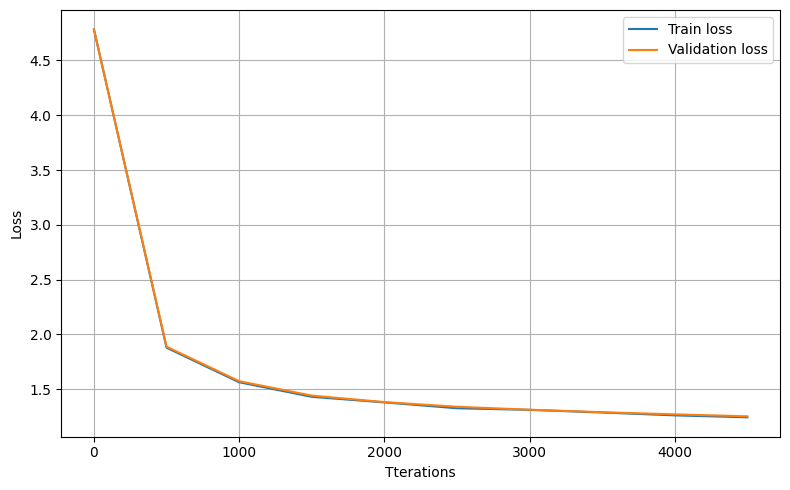

In [26]:
# TODO: Plot the train- and validation loss.
# To speed up training, they are only computed every val_interval iterations. Adapt this value if you like.
# Since dropout is enabled during training, the training loss is computed again during the validation step without dropout.

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(eval_steps, train_losses, label="Train loss")
plt.plot(eval_steps, val_losses, label="Validation loss")
plt.xlabel("Tterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig("figures/train_val_loss.png", dpi=300)


# Sample from the model

In [27]:
num_samples = 5  # Number of samples to draw
max_new_tokens = 500  # Number of tokens generated in each sample.
temperature = 0.8  # TODO: Use different temperature values and qualitatively report on the results
# temperature = 0.2
# temperature = 1.4

# Set seed for reproducibility
seed = 345
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Load the model
checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['model_args']
model = GPT(config)
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)

# Create dataset to get encoder/decoder
dataset = MovieDataset(block_size=config.block_size)
encode = lambda s: [dataset.string_to_int[c] for c in s]
decode = dataset.decode

# TODO: You may change the loop for automated testing
# Generate samples
print('-'*20)
with torch.no_grad():
    for k in range(num_samples):
        start_prompt = "\n"  # TODO: Use different start prompts and compare the results
        # start_prompt = "Once in a land, far, far, away..."
        # start_prompt = "A group of friends"
        # start_prompt = "A young man discovers"
        prompt_ids = encode(start_prompt)

        x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, ...]
        y = model.sample(x, max_new_tokens, temperature=temperature)
        print(decode(y[0]))
        print('-'*20)

/var/folders/m_/4w751xsx21xd9q6gkq4v_nbc0000gn/T/ipykernel_1799/2398746619.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Number of parameters in GPT: 0.83M
--------------------

Beautiful New York Secret: Target: In 1979 life teenage's meddits to leave his new game in the school. But the most dance full as Michean's roading friends most place where teensions must set to become the money test, where high sconnizing respection who throws have to talk her to save him a provicative story in the commandant and encounters the last rising and murder his own.
Sport: Grimmber Band Rambo: A man who lives in attempt to find the boy childrogy back her, elderly plans to get a quit w
--------------------

The Police Door: Two former champion Sara: A team of supply people and Dark Federative artists having abductions, a music teenage genetatival, a vampire broker John Hawk and her hotel they mustangle to pay on a pright, she turns to graces the pressure hero grand people what the commandant becomes a quiet there’s facility and under the year of a property road to police crazy working from her back in the fall of an ins